/home/rizvan/.local/lib/python3.9/site-packages/iminuit/util.py:183: IMinuitWarning: Assigned errors must be positive. Non-positive values are replaced by a heuristic.
  warnings.warn(


Number of chi^2 function calls: 724
Number of degrees of freedom in fit: 463
chi^2 value at minimum: 1006.4274197724066
model parameters: ['z', 't0', 'x0', 'x1', 'c', 'mwebv', 'mwr_v']
best-fit values: [ 9.83141786e-02  5.82653470e+04  8.06785754e-08 -5.71871970e-01
 -7.21424043e-02  3.00000000e-02  3.10000000e+00]
The result contains the following attributes:
 dict_keys(['success', 'message', 'ncall', 'chisq', 'ndof', 'param_names', 'parameters', 'vparam_names', 'covariance', 'errors', 'nfit', 'data_mask'])
           mjd        mag    magerr  clrcoeff  band              oid   
0  58252.43500  20.782143  0.176133 -0.083337  ztfg  796101400003999  \
1  58252.43591  20.686940  0.168897 -0.079771  ztfg  796101400003999   
2  58252.44993  20.875238  0.183209 -0.067942  ztfg  796101400003999   
3  58254.41606  20.351181  0.141318 -0.065270  ztfg  796101400003999   
4  58254.43151  20.233757  0.130986 -0.060281  ztfg  796101400003999   

           flux       fluxerr   zp zpsys  
0  3.66340

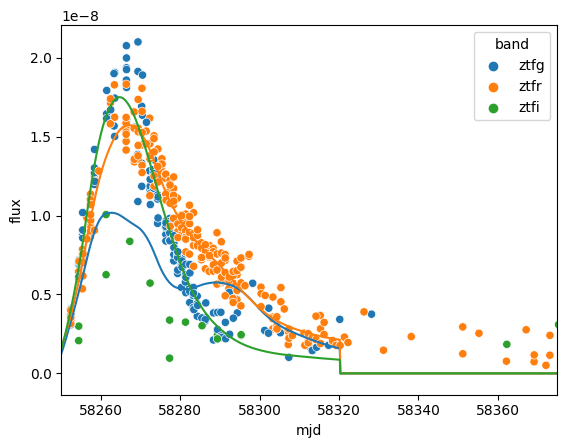

In [11]:
import sncosmo
import sfdmap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table
from Oid_to_ref import oid_to_ref
import requests
from Models_to_parameters import models_to_parameters
import time
import seaborn as sns

import selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC



def mag_flux(data, ref):
    flux = [10 ** (-0.4 * a) - 10 ** (-0.4 * b[0]) for a, b in zip(data['mag'], ref)]
    fluxerr = [((-0.4 * np.log(10) * 10 ** (-0.4 * a) * c) ** 2 + 
                        (-0.4 * np.log(10) * 10 ** (-0.4 * b[0]) * b[1]) ** 2) ** 0.5  for a, b, c, in zip(data['mag'], ref, data['magerr'])]
    return (flux, fluxerr)


def print_params(result):
    print("Number of chi^2 function calls:", result.ncall)
    print("Number of degrees of freedom in fit:", result.ndof)
    print("chi^2 value at minimum:", result.chisq)
    print("model parameters:", result.param_names)
    print("best-fit values:", result.parameters)
    print("The result contains the following attributes:\n", result.keys())

    
def plot(data, fitted_model, result, name_model, a, b, dx, filters):
    #fig = sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)
    #fig.savefig('Fits/' + str(oid) + '_' + name_model)
    #if str(type(filters))=='str': 
        #filters = [filters]
    segment = np.linspace(a, b, dx)
    df_buf = data.to_pandas()
    df = df_buf[df_buf.band.isin(filters)==True]
    print(df.head())
    sns.scatterplot(data=df, x='mjd', y='flux', hue='band')
    for i in filters:
        predicts = [fitted_model.bandflux(i, [point], 8.9, 'ab') for point in segment]#bandflux(self, band, time, zp, zpsys)
        #plt.scatter(data['mjd'], data['flux'], s=8, color='blue')
        plt.plot(segment, predicts)
        plt.xlim(a, b)
    plt.show()

    
def fit(data, name_model, ebv, a, b, dx, filters):
    #ebv = 0.03
    dust = sncosmo.CCM89Dust()
    model = sncosmo.Model(source=name_model, effects=[dust], effect_names=['mw'], effect_frames=['obs'])
    model.set(mwebv=ebv)
    result, fitted_model = sncosmo.fit_lc(data, model, models_to_parameters[name_model], bounds={'z':(0.01, 0.3)})
    print_params(result)
    plot(data, fitted_model, result, name_model, a, b, dx, filters)

    
def give_chrome_option(folder_path):
    chromeOptions = webdriver.ChromeOptions() #setup chrome option
    prefs = {"download.default_directory" : folder_path,
           "download.prompt_for_download": False,
           "download.directory_upgrade": True}  #set path
    chromeOptions.add_experimental_option("prefs", prefs) #set option
    #chromeOptions.add_argument("--headless")
    return chromeOptions


def get_data(ra, dec, radius):
    
    #/api/v3/data/latest/oid/full/json?oid=830202400008402
    #BASE_URL = 'http://db.ztf.snad.space/api/v3/data/latest/oid/full/json?oid=' + str(oid)
    BASE_URL = 'http://db.ztf.snad.space/api/v3/data/latest/circle/full/json?ra=' + str(ra) + '&dec=' + str(dec) + '&radius_arcsec=' + str(radius)
    json = requests.get(f"{BASE_URL}").json()
    #data = [pd.DataFrame.from_records(json[i]['lc']) for i in json.keys()]
    #print(data)
    #it = 0
    data = []
    for i in json.keys():
        buf_df = pd.DataFrame.from_records(json[i]['lc'])
        buf_df['band'] = json[i]['meta']['filter']
        buf_df['oid'] = int(i)
        data.append(buf_df)
        #it += 1
    #i['oid'] = oid for i, oid in data, json.keys()
    #lc = data['lc']
    #for i in range (len(data)):
        #data[i]['oid'] = json.keys()[i]
    df = pd.concat([i for i in data], axis=0, sort=False, ignore_index=True)
    
    #print(df['oid'].unique()[1])
    folder_path = f'home/Downloads'
    driver = webdriver.Chrome(options = give_chrome_option(folder_path))
    url = "https://ztf.snad.space/dr17/view/" + str(df['oid'][1])
    driver.get(url)
    time.sleep(15)
    base = driver.find_element(By.ID, "summary")
    #ebv = float(base.text.split('\n')[5][-4:])
    for i in base.text.split('\n'):
        if i.split(':')[0]=='Extinction':
            ebv = float(i[-4:])
    base = driver.find_element(By.XPATH, '//*[@id="light-curve-brightness"]/label[4]/input').click()
    #base = driver.find_element(By.XPATH, "//*[@id='ref-mag']").get_attribute('text')
    #print(base)
    return df, ebv


def aproximate(ra, dec, radius, name_model, a, b, dx, filters):
    #data = pd.read_csv(str(oid) + ".csv")
    #print('OID:', oid, ' ', 'MODEL:', name_model)
    data, ebv = get_data(ra, dec, radius)
    #ref = data['oid'].map(oid_to_ref[oid])
    for i in data['oid'].unique():
        if i in oid_to_ref.keys():
            ref = data['oid'].map(oid_to_ref[i])
    #data['mag_d'] = [-2.5 * np.log10(10 ** (-0.4 * a) - 10 ** (-0.4 * b[0])) for a, b in zip(data['mag'], ref)]
    data['flux'], data['fluxerr'] = mag_flux(data, ref)
    data['zp'] = 8.9
    data['zpsys'] = 'ab'
    data['band'] = data['band'].str.replace('z', 'ztf')
    data = Table.from_pandas(data)
    dust = sncosmo.CCM89Dust()
    fit(data, name_model, ebv, a, b, dx, filters)

#aproximate(633207400004730, 'salt2')
aproximate(263.37726, 51.25848, 1, 'salt2', 58250, 58375, 1000, ['ztfi', 'ztfr', 'ztfg'])